# 1. Import CellRefiner and packages

In [18]:
import numpy as np
import pandas as pd
import squidpy as sq
from cellrefiner import cellrefiner
import seaborn as sns

# 2. Load Data

The paired datasets here are from Visium spatial transcriptomic data and scRNA-seq samples of the mouse cortex available via the squidpy package.

In [3]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])].copy()
adata_sc = sq.datasets.sc_mouse_cortex()

Load the mouse ligand-receptor database from local path, originally sourced from CellChat

In [4]:
db = pd.read_csv(R'LR.csv')

Here we convert the gene names to entirely lower case. 

In [5]:
adata_sc.var_names = adata_sc.var_names.str.lower()
adata_st.var_names = adata_st.var_names.str.lower()
db['interaction_name'] = db['interaction_name'].apply(str.lower)

# 3. Create CellRefiner object

We create the CellRefiner object using spatial transcriptomic gene expression and spatial data, paired scRNA-seq data, and a ligand receptor database.

In [6]:
cr = cellrefiner.CellRefiner(adata_st=adata_st,adata_sc=adata_sc,db=db)

Parameters:
- ```adata_st```: AnnData object as input for spatial transcriptomic data (i.e. Visium)
- ```adata_sc```: AnnData object as input for scRNA-seq data
- ```db```: ligand receptor database as pandas dataframe

Generate ligand receptor affinity matrix.

In [7]:
cr.gen_w()

For faster computation, the affinity matrix can also be loaded if precalculated.

In [ ]:
cr.W = np.load("W1.npy")

# 4. Preprocessing

Preprocess the data. Here the cell identities are annotated under ```adata_sc.obs['cell_subclass']``` and the data is otherwise preprocessed.

Parameters:
- ```device```: Default is ```cuda:0``` assuming CUDA is available, otherwise set to ```cpu```.
- ```group```: Set as the annotation of the cell identities in the scRNA-seq dataset, found in ```adata_sc.obs```.

In [13]:
cr.pp_cr(group = "cell_subclass")

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.613, KL reg: 0.001
Score: 0.733, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000


INFO:root:Saving results..


# 5. Simulation

Run the physical simulation.

In [16]:
cr.sim_cr(iterations=10,W=cr.W,tissue_bound=1)

Parameters:
- ```iterations```: number of iterations, default is 30
-```W```: Ligand receptor affinity matrix, default is none.
-```tissue_bound```: set as ```1``` to impose a tissue boundary, default is ```0```.
-```dt```: time step, default is 0.0028.
-```m_val```: cell density scaling parameter, set lower values for tissue with higher cell density. Default is 125.
-```rS```: Distance between centers of spots in microns, default is 100.

# 6. Visualization

Plot the CellRefiner output for all cell identities. Here we flip the y-coordinates of the positional data to match the common view of this sample of mouse cortex slice; our coordinate system is the same as the original Visium data.

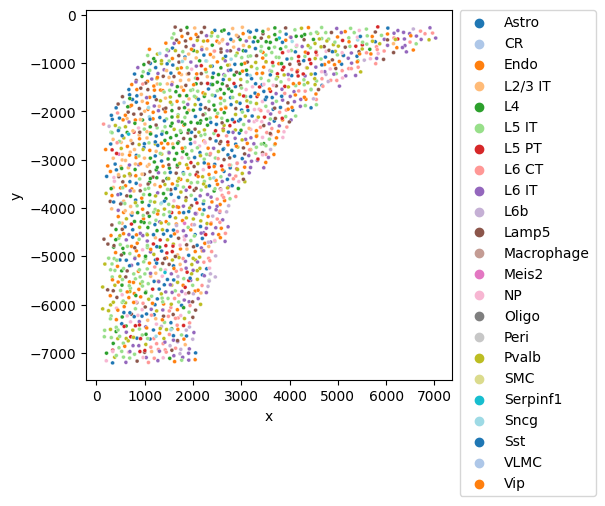

In [37]:
df=pd.DataFrame({"x":cr.pos[-1,:,0],"y":-cr.pos[-1,:,1],"cell_type": pd.Categorical(adata_sc.obs['cell_subclass'][cr.cell5m])},columns=['x','y','cell_type'])
sns.scatterplot(data=df,x="x",y="y",hue="cell_type",s=8*np.ones(df.shape[0]),palette='tab20')
plt.legend(bbox_to_anchor=(1.02,1),loc='upper left',borderaxespad=0)
plt.gca().set_aspect('equal')

Plot the CellRefiner output for a specific cell identity, L4 in orange.

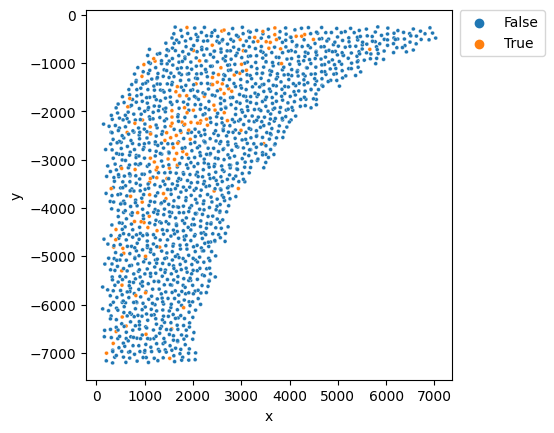

In [44]:
cell_identity = 'L4'
df = pd.DataFrame({"x":cr.pos[-1,:,0],"y":-cr.pos[-1,:,1],"cell_type": pd.Categorical(adata_sc.obs['cell_subclass'][cr.cell5m]==cell_identity)},columns=['x','y','cell_type'])
sns.scatterplot(data=df,x="x",y="y",hue="cell_type",s=8*np.ones(df.shape[0]),cmap='bwr')
plt.legend(bbox_to_anchor=(1.02,1),loc='upper left',borderaxespad=0)
plt.gca().set_aspect('equal')